In [72]:
import numpy as np
from scipy.integrate import solve_ivp
from functools import partial
import matplotlib.pyplot as plt

class Planet:
    def __init__(self, name, r, m, v):
        self.name = name
        self.r = r #vector
        self.m = m
        self.v = v #vector

class System:
    def __init__(self):
        self.planets = []
    def add_planet(self, planet):
        self.planets.append(planet)
    
    def equations(self, t, s, m):
        # s = [r;v] = [rx, ry, rz, vx, vy, vz] has length 6n
        # ds/dt = [v;F/m]
        #A = [[0, 1], [F/m, 0]]
        G = 6.674 * 10**-11
        n = len(self.planets)
        A = np.zeros((n*2, n*2))
        s_v=np.array([s[i:i+3] for i in range(0, 6*n, 3)])
        #print(s_v)
        #plt.plot(s_v[:2,0], s_v[:2,1], 'o')
        for i in range(n):
            A[i][n+i] = 1
            for j in range(n):
                if i != j:
                    A[i+n][j] = G * m[j] / (np.linalg.norm(s_v[i] - s_v[j])**3)
                else:
                    A[i+n][j] = -1 * np.sum([G * m[k] / (np.linalg.norm(s_v[i] - s_v[k])**3) for k in range(n) if k != i])
        B = np.zeros((n*6,n*6))
        for i in range(n):
            B[3*i][3*n+3*i] = 1
            B[3*i+1][3*n+3*i+1] = 1
            B[3*i+2][3*n+3*i+2] = 1
            for j in range(n):
                if A[i+n][j] != 0:
                    B[3*n+3*i][3*j] = A[i+n][j]
                    B[3*n+3*i+1][3*j+1] = A[i+n][j]
                    B[3*n+3*i+2][3*j+2] = A[i+n][j]
        #print(A)
        #print(B)
        return np.dot(B,s)
    
    def update(self, dt):
        r = np.array([list(p.r) for p in self.planets])
        v = np.array([list(p.v) for p in self.planets])
        s = np.vstack((r, v)).flatten()
        t=np.linspace(0, dt, dt*2) #update 2 times per sec
        #print(self.equations(0, s, np.array([p.m for p in self.planets])))
        #print(s.flatten())

        f = partial(self.equations, m=[p.m for p in self.planets])
        sol = solve_ivp(f, [0, dt], s, t_eval=t)
        n = len(self.planets)
        for i, p in enumerate(self.planets):
            p.r = np.array([sol.y[3*i][-1], sol.y[3*i+1][-1], sol.y[3*i+2][-1]])
            p.v = np.array([sol.y[3*n+3*i][-1], sol.y[3*n+3*i+1][-1], sol.y[3*n+3*i+2][-1]])
        return sol.y

    
def sphere2cart(r, theta, phi):
    #translate sphere coordinates to cartesian coordinates
    #[r, theta, phi] -> [x, y, z]
    return np.array([r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), r * np.cos(theta)])
def cart2sphere(x, y, z):
    #translate cartesian coordinates to sphere coordinates
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return np.array([r, theta, phi])



In [73]:
p1 = Planet("Earth", np.array([0,0,0]), 5.972 * 10**24, np.array([-10, 0, 0]))
p2 = Planet("Moon", np.array([0,384400000,0]), 7.342 * 10**22, np.array([1200, 0, 0]))
#p3 = Planet("sate", np.array([1000,0,0]), 3000, np.array([0, .2*1000, 0]))
s = System()
#initial energy, momentum, and angular momentum
U0 = 0.5 * p1.m * np.linalg.norm(p1.v)**2 + 0.5 * p2.m * np.linalg.norm(p2.v)**2 #- 6.674 * 10**-11 * p1.m * p2.m / np.linalg.norm(p1.r - p2.r)
P0 = p1.m * p1.v + p2.m * p2.v
T0 = np.cross(p1.r, p1.m * p1.v) + np.cross(p2.r, p2.m * p2.v)
s.add_planet(p1)
s.add_planet(p2)
#s.add_planet(p3)
sol = s.update(60*24*60*60)

array([21837119.4955833 ,   494295.18196586,        0.        ])

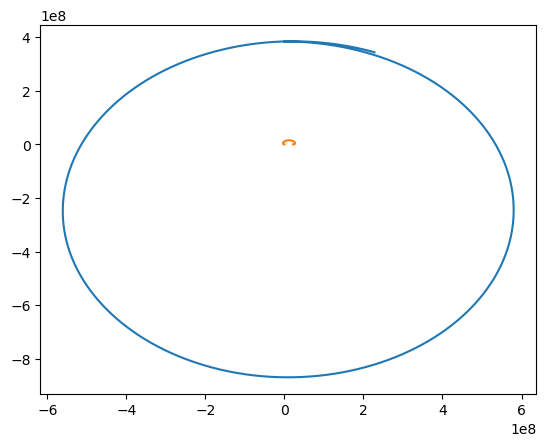

In [74]:
display(s.planets[0].r, s.planets[1])
fig = plt.figure()
plt.plot(sol[3], sol[4])
plt.plot(sol[0],sol[1])
#plt.plot(sol[6],sol[7])

In [75]:
p1.v = s.planets[0].v
p2.v = s.planets[1].v
U = 0.5 * p1.m * np.linalg.norm(p1.v)**2 + 0.5 * p2.m * np.linalg.norm(p2.v)**2 #- 6.674 * 10**-11 * p1.m * p2.m / np.linalg.norm(p1.r - p2.r)
P = p1.m * p1.v + p2.m * p2.v
T = np.cross(p1.r, p1.m * p1.v) + np.cross(p2.r, p2.m * p2.v)
U,U0,P,P0, T, T0

(4.988577558691859e+28,
 5.3161e+28,
 array([ 2.83840000e+25, -1.15964117e+11,  0.00000000e+00]),
 array([2.8384e+25, 0.0000e+00, 0.0000e+00]),
 array([ 0.00000000e+00,  0.00000000e+00, -3.38275603e+34]),
 array([ 0.00000000e+00,  0.00000000e+00, -3.38671776e+34]))

***TODO***:
add energy correction & angular momentum correction //
add orbit & temp